In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils
from skimage import color
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import PIL as image_lib
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
#from keras.layers.core import Dense
#from tensorflow.keras.layers import dense
from sklearn.metrics import confusion_matrix,classification_report

import itertools 
import datetime

import io

In [2]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('cleaned/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image
        image = cv2.resize(image, (image_size, image_size)) 
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('cleaned/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images 
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)


100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 119.49it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


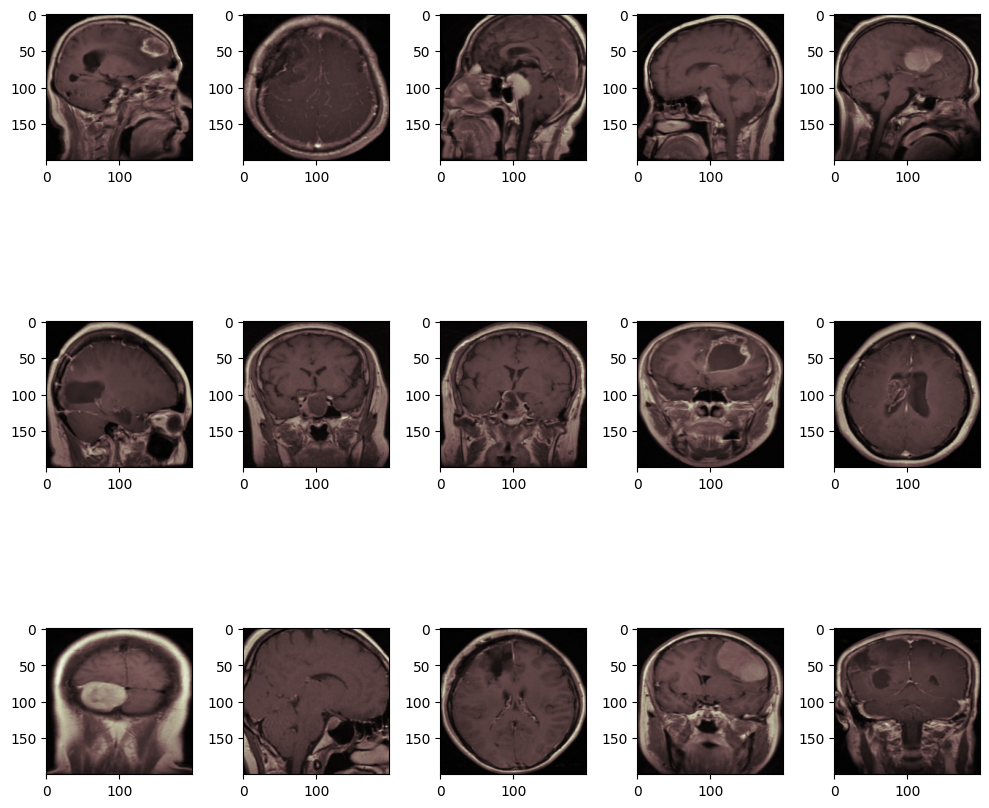

In [10]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [3]:
#randomize dataset
x_train, y_train= shuffle(x_train, y_train, random_state=99)
x_test, y_test= shuffle(x_test, y_test, random_state=99)

In [ ]:
# x_train.astype(np.unint8) just incase memory error
# x_test.astype(np.unint8)
# y_train.astype(np.unint8)
# y_test.astype(np.unint8)

In [4]:
#one Hot Encoding on the labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [5]:
print(x_train.shape)
print(x_test.shape)

(5712, 200, 200, 3)
(1311, 200, 200, 3)


In [6]:
#Augment data to reduce overfitting and improve accuracy
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

datagen.fit(x_train)


In [7]:
VGG16 = VGG16(input_shape=(200, 200, 3),
                     include_top=False,
                     weights='imagenet')

In [8]:
model = VGG16.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= VGG16.input, outputs= model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [9]:



class_names = list(labels)
def plot_to_image(figure):    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names): 
    figure = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
    plt.title("Confusion matrix") 
    plt.colorbar() 
    tick_marks = np.arange(len(class_names)) 
    plt.xticks(tick_marks, class_names, rotation=45) 
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
    threshold = cm.max() / 2. 

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        color = "white" if cm[i, j] > threshold else "black"   
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  
    
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

    return figure


def log_confusion_matrix(epoch, logs):
    predictions = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test,axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)



logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


     

In [11]:
file_writer_cm = tf.summary.create_file_writer(logdir)


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_test,y_test),epochs = EPOCHS,callbacks = callbacks)


Epoch 1/50
286/286 [==============================] - ETA: 0s - loss: 0.9076 - accuracy: 0.6106
Epoch 1: val_loss improved from inf to 0.53557, saving model to model-01-0.79-0.54.h5


C:\Users\lvpra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 2962s 10s/step - loss: 0.9076 - accuracy: 0.6106 - val_loss: 0.5356 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 2/50
286/286 [==============================] - ETA: 0s - loss: 0.3692 - accuracy: 0.8708
Epoch 2: val_loss improved from 0.53557 to 0.39932, saving model to model-02-0.86-0.40.h5


C:\Users\lvpra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 2283s 8s/step - loss: 0.3692 - accuracy: 0.8708 - val_loss: 0.3993 - val_accuracy: 0.8574 - lr: 1.0000e-04
Epoch 3/50
286/286 [==============================] - ETA: 0s - loss: 0.2789 - accuracy: 0.9060
Epoch 3: val_loss improved from 0.39932 to 0.22575, saving model to model-03-0.92-0.23.h5


C:\Users\lvpra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 2256s 8s/step - loss: 0.2789 - accuracy: 0.9060 - val_loss: 0.2257 - val_accuracy: 0.9169 - lr: 1.0000e-04
Epoch 4/50
286/286 [==============================] - ETA: 0s - loss: 0.1880 - accuracy: 0.9340
Epoch 4: val_loss improved from 0.22575 to 0.18275, saving model to model-04-0.94-0.18.h5


C:\Users\lvpra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 2251s 8s/step - loss: 0.1880 - accuracy: 0.9340 - val_loss: 0.1827 - val_accuracy: 0.9420 - lr: 1.0000e-04
Epoch 5/50
286/286 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9464
Epoch 5: val_loss did not improve from 0.18275
286/286 [==============================] - 2245s 8s/step - loss: 0.1623 - accuracy: 0.9464 - val_loss: 0.2318 - val_accuracy: 0.9268 - lr: 1.0000e-04
Epoch 6/50
286/286 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.9578
Epoch 6: val_loss improved from 0.18275 to 0.09121, saving model to model-06-0.97-0.09.h5


C:\Users\lvpra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 2254s 8s/step - loss: 0.1262 - accuracy: 0.9578 - val_loss: 0.0912 - val_accuracy: 0.9695 - lr: 1.0000e-04
Epoch 7/50
286/286 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.9615
Epoch 7: val_loss did not improve from 0.09121
286/286 [==============================] - 2260s 8s/step - loss: 0.1189 - accuracy: 0.9615 - val_loss: 0.2718 - val_accuracy: 0.9291 - lr: 1.0000e-04
Epoch 8/50
286/286 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9648
Epoch 8: val_loss did not improve from 0.09121
286/286 [==============================] - 2268s 8s/step - loss: 0.1049 - accuracy: 0.9648 - val_loss: 0.1402 - val_accuracy: 0.9573 - lr: 1.0000e-04
Epoch 9/50
286/286 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9704
Epoch 9: val_loss improved from 0.09121 to 0.05770, saving model to model-09-0.98-0.06.h5


C:\Users\lvpra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 2224s 8s/step - loss: 0.0892 - accuracy: 0.9704 - val_loss: 0.0577 - val_accuracy: 0.9794 - lr: 1.0000e-04
Epoch 10/50
286/286 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9792
Epoch 10: val_loss did not improve from 0.05770
286/286 [==============================] - 2216s 8s/step - loss: 0.0677 - accuracy: 0.9792 - val_loss: 0.2101 - val_accuracy: 0.9573 - lr: 1.0000e-04
Epoch 11/50
286/286 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.9807
Epoch 11: val_loss improved from 0.05770 to 0.04791, saving model to model-11-0.98-0.05.h5


C:\Users\lvpra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 2219s 8s/step - loss: 0.0640 - accuracy: 0.9807 - val_loss: 0.0479 - val_accuracy: 0.9847 - lr: 1.0000e-04
Epoch 12/50
286/286 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.9751
Epoch 12: val_loss did not improve from 0.04791
286/286 [==============================] - 2187s 8s/step - loss: 0.0776 - accuracy: 0.9751 - val_loss: 0.0748 - val_accuracy: 0.9764 - lr: 1.0000e-04
Epoch 13/50
286/286 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9851
Epoch 13: val_loss did not improve from 0.04791
286/286 [==============================] - 2186s 8s/step - loss: 0.0442 - accuracy: 0.9851 - val_loss: 0.0983 - val_accuracy: 0.9741 - lr: 1.0000e-04
Epoch 14/50
286/286 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 0.9841
Epoch 14: val_loss did not improve from 0.04791
286/286 [==============================] - 2182s 8s/step - loss: 0.0574 - accuracy: 0.9841 - val_loss: 0.1287 - val

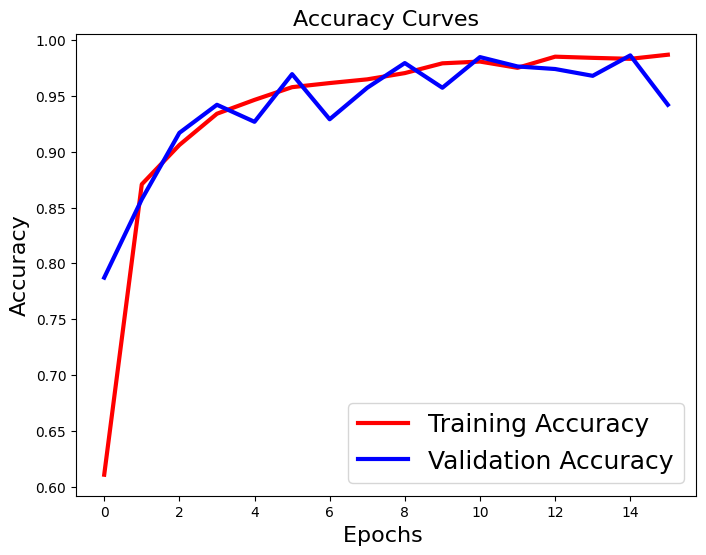

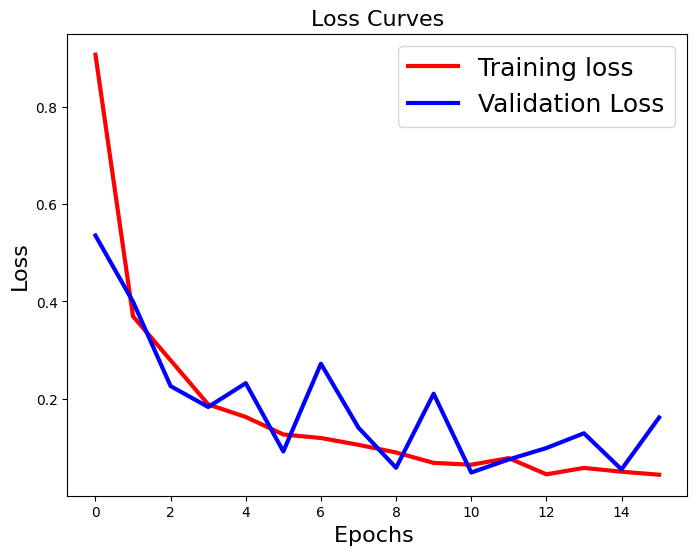

In [12]:
#Accuracy curve
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

#Loss Curve
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

41/41 [==============================] - 107s 3s/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       300
           1       0.98      0.98      0.98       306
           2       1.00      0.99      0.99       405
           3       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



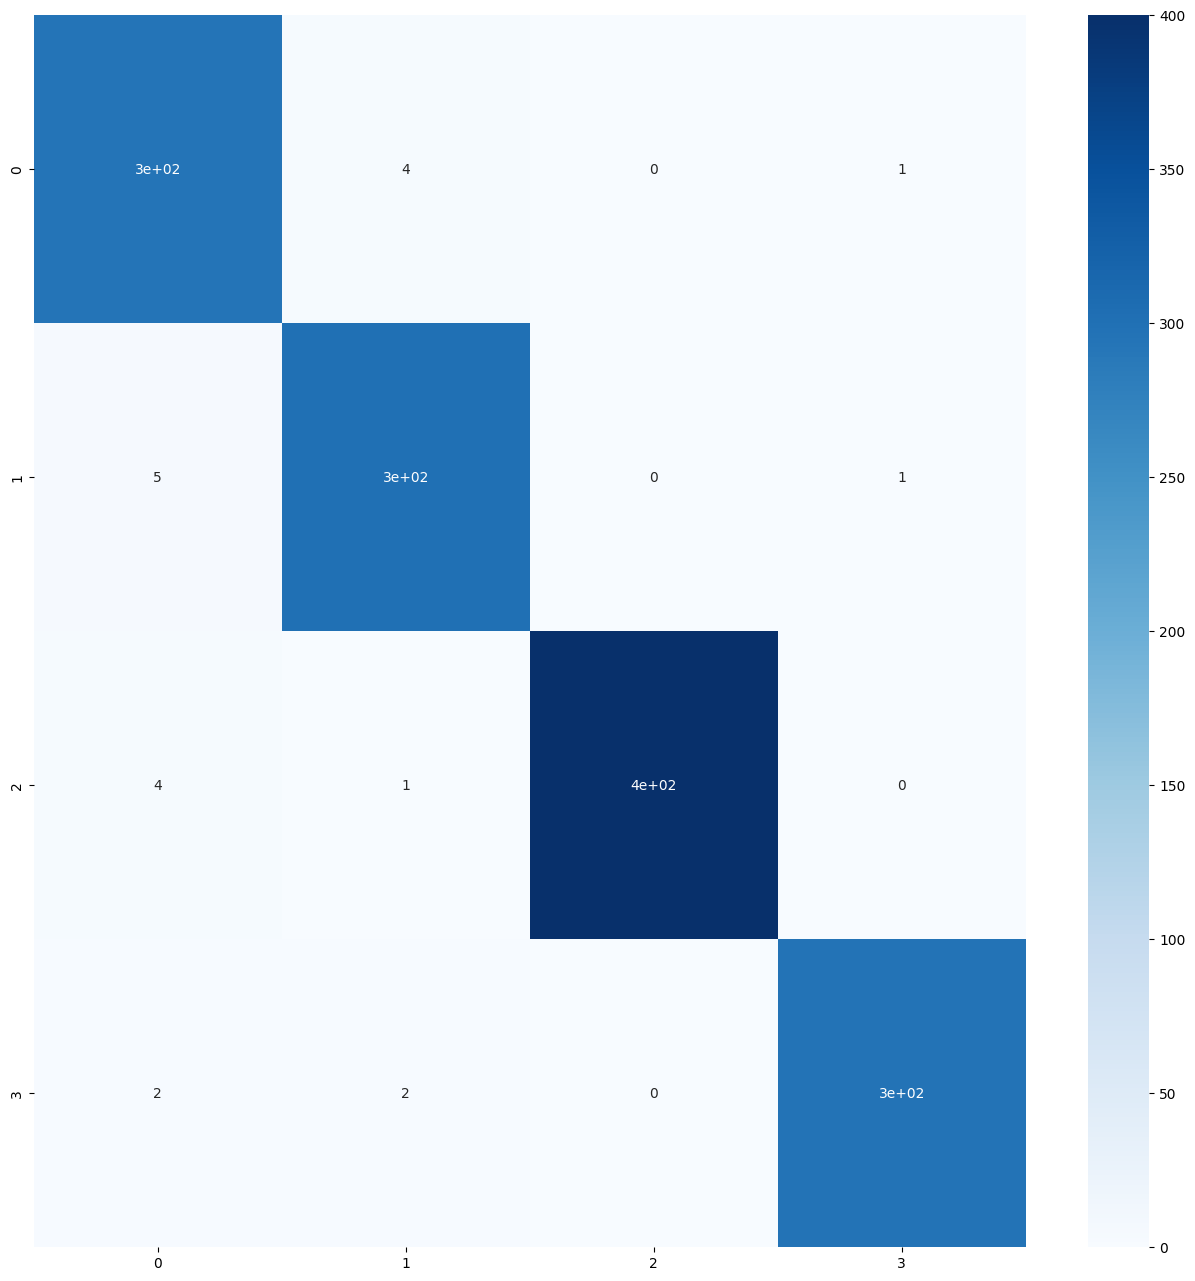

In [13]:
#Eval

predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [14]:
loss,acc = model.evaluate(x_test,y_test)

41/41 [==============================] - 106s 3s/step - loss: 0.0479 - accuracy: 0.9847
